In [6]:
import numpy as np
import warnings
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from scipy.special import expit
from sklearn import metrics

from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle

Model parameters:

In [7]:
seed = 5
test_size = 0.1
split_num = 10

CDF:

In [8]:
def plot_learning_curve(est, x, y, cv=None, n=None, train_sizes=np.linspace(.1, 1.0, 300)):
    plt.figure()
    plt.xlabel('Training sample')
    plt.ylabel('Precision')
    
    tr_sizes, tr_scores, ts_scores = learning_curve(est, x, y, cv=cv, n_jobs=n, train_sizes=train_sizes, scoring='precision')
    train_scores_mean = np.mean(tr_scores, axis=1)
    test_scores_mean = np.mean(ts_scores, axis=1)
    
    plt.plot(tr_sizes, train_scores_mean, '.-', color='r', label='training precision')
    plt.plot(tr_sizes, test_scores_mean, '.-', color='g', label='cross-validation precision')
    plt.legend(loc='best')
    
    return plt

Supress warnings:

In [9]:
warnings.filterwarnings('ignore')

Read xlsx:

In [18]:
df = pd.read_excel('data/sample.xlsx', index_col=0)

Shuffle sample:

In [19]:
df_cv = shuffle(df).reset_index(drop=True)
df_cv.head(0)

,model_name_devices,category_market,vendor_market,model_name_market,score,category_match_operator,model_match_operator


Print sample size:

In [20]:
print('Sample size:', len(df_cv))

Sample size: 1162


Show score distribution:

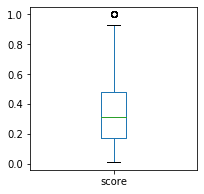

In [21]:
df_cv[['score']].boxplot(grid=False, figsize=(3,3))
plt.show()

Define array for model definition:

In [22]:
X = np.reshape(df_cv.values[:, 4], (len(df_cv), 1)).astype('float')
Y = np.reshape(df_cv.values[:, 6], (len(df_cv), 1)).astype('int')

Show metrics of model definition:

In [23]:
model = LogisticRegression(solver='newton-cg')
kfold = KFold(n_splits=split_num, random_state=seed)

roc_auc = cross_val_score(model, X, Y, cv=kfold, scoring='roc_auc')
precision = cross_val_score(model, X, Y, cv=kfold, scoring='precision')

print('CV roc_auc: %.0f%% (%.0f%%)' % (roc_auc.mean()*100.0, roc_auc.std()*100.0))
print('CV precision: %.0f%% (%.0f%%)' % (precision.mean()*100.0, precision.std()*100.0))

CV roc_auc: 93% (1%)
CV precision: 82% (9%)


Precision as function of score:

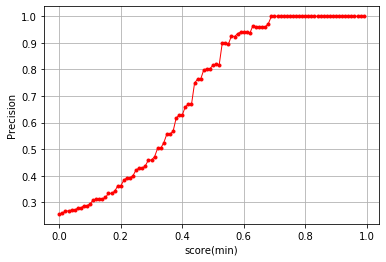

In [24]:
s_list = []
p_list = []

for s in range(100):
    s_min = 0.01*s
    
    true_pos = df_cv[df_cv['score'] > s_min]['model_match_operator'].sum()
    sigma = df_cv[df_cv['score'] > s_min]['model_match_operator'].count() 
    prec = true_pos/sigma
    
    s_list.append(s_min)
    p_list.append(prec)
    
plt.plot(s_list, p_list, '.-', color='red', linewidth=1)

plt.xlabel('score(min)')
plt.ylabel('Precision')

plt.grid()
plt.show()    

Show log regression mapping:

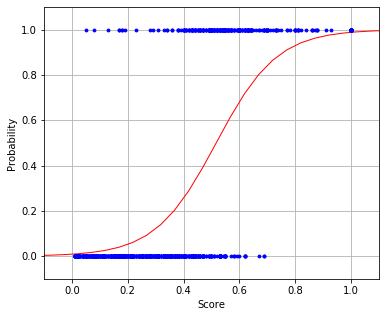

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
model = LogisticRegression(solver='newton-cg')
model.fit(X_train, Y_train)

plt.figure(1, figsize=(6, 5))
plt.scatter(X.ravel(), Y, color='blue', zorder=10, s=8)
X_test = np.linspace(-5, 10, 300)

loss = expit(X_test * model.coef_ + model.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=1)

plt.ylim(-0.1, 1.1)
plt.xlim(-0.1, 1.1)

plt.xlabel('Score')
plt.ylabel('Probability')

plt.grid()
plt.show()

Hold-out metrics:

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model = LogisticRegression(solver='newton-cg')
model.fit(X_train, Y_train)
predicted = model.predict(X_test)

roc_auc = float(roc_auc_score(Y_test, predicted))
precision = float(precision_score(Y_test, predicted))

print('Hold-out roc_auc:', round(roc_auc*100), '%')
print('Hold-out precision:', round(precision*100), '%')

Hold-out roc_auc: 82 %
Hold-out precision: 78 %


Learning curve:

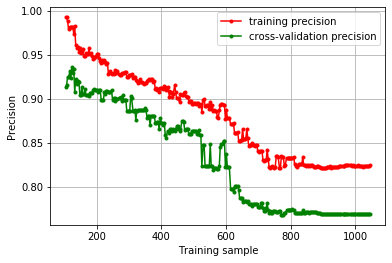

In [27]:
model = LogisticRegression(solver='newton-cg')
cv = ShuffleSplit(n_splits=split_num, test_size=test_size, random_state=seed)
plot_learning_curve(model, X, Y, cv=cv, n=-1)
plt.grid()
plt.show()

Scattering of LogReg parameters:

In [28]:
factor = []
slope = []
model = LogisticRegression(solver='newton-cg')

for i in range(1000): 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    model.fit(X_train, Y_train)
    
    factor.append(float(model.coef_))
    slope.append(float(model.intercept_))
    
print('LogReg factor variance:', abs(int(round(100*np.std(factor)/np.mean(factor)))), '%')
print('LogReg slope variance:', abs(int(round(100*np.std(slope)/np.mean(slope)))), '%')

LogReg factor variance: 1 %
LogReg slope variance: 1 %
